#### **Automated Slow Oscillations and Sleep Spindles Event Detection Pipeline Tutorial**

This document introduces a PSG event detection pipeline that includes the automated detection for slow oscillations and sleep spindles using various customizable methods and parameters. Users can either follow a standardized procedure for rapid processing of all files or customize the functions based on their analysis.

In [2]:
# ----------------- Load packages ------------------- #
import os
import contextlib
import io
import numpy as np
import pandas as pd
import mne
from scipy.io import loadmat
from AutoPSG import *
from AutoPSG.artifact_detect import load_raw, load_hypnogram_data, good_epoch_dur, hypnogram_segment
from AutoPSG.event_detect import SO_detection, plot_SO, SP_detection, plot_SP, PAC
import tensorpac

ImportError: cannot import name 'PAC' from 'AutoPSG.event_detect' (/Users/theang/Desktop/EMO_PSG_fMRI/code_func/emopsg/Code/AutoPSG/AutoPSG/event_detect.py)

**Standardized Event detection precedures:**

The data structure before event detecton should be similar to:

- data
  - preproc
    - PSG_01_wordtask.fif
    - PSG_02_wordtask.fif
    - ...
  - scoring
    - PSG_01_wordtask.mat
    - PSG_02_wordtask.mat
    - ...

1. Load preprocessed EEG raw data and sleep stage scoring file
2. Run!

We **strongly encourage** users to reference the raw data to the contralateral mastoids (M1 and M2) before event detection.

It is the default setting if you use our preprocessing pipeline.

There are six slow oscillation detection methods available:
1. Staresina, use percentile threshold: top 25% PTP
2. Ng, use adjusted percentile threshold: top 30% PTP & top 30% trough
3. Massimini, (and Dang-Vu) use absolute threshold: trough < -80µv & trough-to-peak > 140µv
4. Dimulescu, use adjusted absolute threshold: trough < -40µv & trough-to-peak > 70µv
5. Molle, use relative threshold: trough > 2/3 mean trough & event PTP > 2/3 mean PTP
6. Ngo, use adjusted relative threshold: trough > 1.25 mean trough & event PTP > 1.25 mean PTP

There are five sleep spindle detection methods available:
1. Hahn, 2020: Bandpass filter: 12–16 Hz, Uses Hilbert transform and a smoothed amplitude envelope, top 25% amplitude.
2. Martin, 2013: Bandpass filter: 11–15 Hz, Root mean square (RMS) envelope with a 250 ms window, 95th percentile of RMS values.
3. Wamsley, 2012: Wavelet-based approach, time-frequency transform using a Morlet wavelet.
    Rectified moving average of the wavelet signal with a 100 ms window. Threshold: 4.5 times the mean amplitude.
4. Wendt, 2012: Bandpass filter: 11–16 Hz using equiripple filters,
    Dual detectors with time-varying thresholds (3 μV and 8 μV offsets).
5. Ferrarelli, 2007: Bandpass filter: 12–15 Hz,
    Rectified signal; thresholds based on 2x (lower) and 8x (upper) the mean amplitude. Boundaries defined by crossings of thresholds.

Preferred Phase:    -1.8 rad
Modulation Index:    0.97
Mean Vector Length:  0.78
Rayleigh z:          122.38
p-value:             0.00


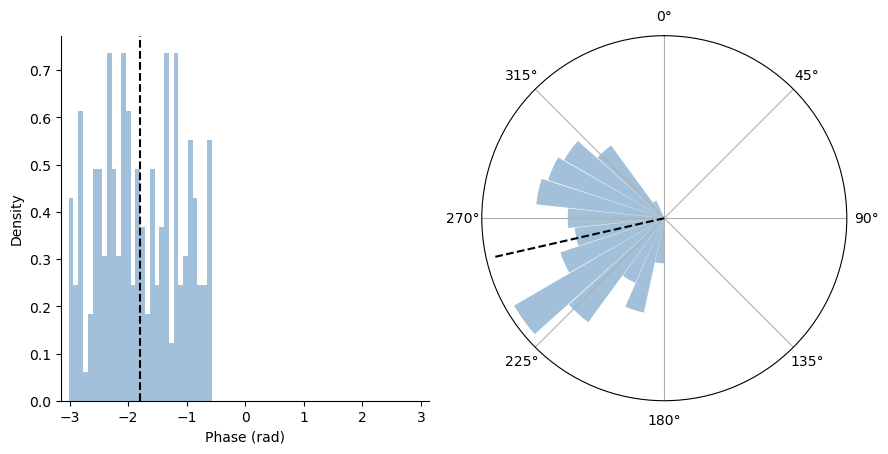

In [8]:
##################################### Parameter Settings for the Pipeline ######################################
os.chdir('/Users/somneuro/Desktop/PSG/data')
processed_file = 'preproc/'
scoring_file = 'scoring/'
montage_temp = 'standard_1005'
interest_stage = ['N2', 'SWS'] # Only detect events in selected stages.
rerefer = True # If reference channels are not mostoids or you are unsure
scoring_dur = 30 # (in seconds) the duration of each epoch used for sleep scoring
chan_limit = None # Use None to detect events in all channels, or use ['Fz', 'Cz', ...] to detect in selected channels only.

###################################### Automated Event Detection Pipeline ######################################
## DO NOT CHANGE THE FOLLOWING CODE IF YOU DO NOT PLAN TO MODIFY, DEBUG, OR CUSTOMIZE THE EVENT DETECTION STEPS
file_paths = [os.path.join(processed_file, f) for f in os.listdir(processed_file) if f.endswith(('.vhdr', '.edf', '.fif', '.set', '.fdt', '.bdf', '.cnt'))]
SO_candidate_all = []
SP_candidate_all = []

for file_path in file_paths:
    id = os.path.splitext(os.path.basename(file_path))[0]
    print(f"\033[1mStart event detection for subject {id}.\033[0m")
    raw = load_raw(file_path)
    if chan_limit is not None:
        raw = raw.pick_channels(raw.info["ch_names"], include=chan_limit)
    if rerefer:
        raw.set_eeg_reference(ref_channels=(rerefer))
    stage = hypnogram_segment(raw=raw, interval=scoring_dur, file_paths=os.path.join(scoring_file, f"{id}.mat"))

    _, SO_candidate = SO_detection(raw, stage, interest_stage, method='Staresina', baseline=True)
    ## plot_SO(SO_candidate, raw, grp_thres=0.5, sync_trough=True, interact=True, multilayer=False)
    _, SP_candidate = SP_detection(raw, stage, interest_stage, method="hahn2020", baseline=True)
    ## plot_SP(SP_candidate, raw, grp_thres=0.5, sync_peak=False, interact=False, multilayer=False)

    SO_candidate["Subject"] = id
    SO_candidate_all.append(SO_candidate)

    SP_candidate["Subject"] = id
    SP_candidate_all.append(SP_candidate)

SO_candidate_all_df = pd.concat(SO_candidate_all, ignore_index=True)
SP_candidate_all_df = pd.concat(SP_candidate_all, ignore_index=True)
Coupling_event = Event_lock(SO_candidate, SP_candidate)
PAC(Coupling_event)

**Customized event detection**

- Instead of directly use pre-specified parameters, you can choose to set your own parameters with the following code.

In [ ]:
SO_detection(raw, stage, interest_stage, filter_freq=None, duration=None, baseline=True, filter_type='fir', method='Staresina')
SP_detection(raw, stage, interest_stage, l_freq=None, h_freq=None, dur_lower=None, dur_upper=None, method="hahn2020", baseline=True)